# Imports and Path Setup

In [2]:
import os
import math
import random
import logging
import datetime
import warnings
import numpy as np
import cv2
import h5py
import torch
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from einops import rearrange
from tqdm import tqdm

# Set specific paths
PROJECT_ROOT = "/home/shasvat/mtp/mst_plus_plus"
DATA_ROOT = "/home/shasvat/NAS/data/mst_plus_plus/dataset"
EXP_DIR = os.path.join(PROJECT_ROOT, "exp", "mst_plus_plus")
RESUME_SUBFOLDER = "xx"
RESUME_DIR = os.path.join(EXP_DIR, RESUME_SUBFOLDER)

os.makedirs(EXP_DIR, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Root:    {DATA_ROOT}")
print(f"Exp Dir:      {EXP_DIR}")

# Set GPU Device
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Project Root: /home/shasvat/mtp/mst_plus_plus
Data Root:    /home/shasvat/NAS/data/mst_plus_plus/dataset
Exp Dir:      /home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus
Using device: cuda


# Utility Functions (Loss, Metrics, Logging)

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def initialize_logger(file_dir):
    logger = logging.getLogger(str(file_dir))
    logger.handlers.clear()
    fhandler = logging.FileHandler(filename=file_dir, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(message)s', "%Y-%m-%d %H:%M:%S")
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    logger.setLevel(logging.INFO)
    return logger

def save_checkpoint(model_path, epoch, iteration, model, optimizer):
    state = {
        'epoch': epoch,
        'iter': iteration,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, os.path.join(model_path, 'net_%depoch.pth' % epoch))

class Loss_MRAE(nn.Module):
    def __init__(self):
        super(Loss_MRAE, self).__init__()
    def forward(self, outputs, label):
        assert outputs.shape == label.shape
        error = torch.abs(outputs - label) / label
        mrae = torch.mean(error.reshape(-1))
        return mrae

class Loss_MRAE_custom(nn.Module):
    def __init__(self):
        super(Loss_MRAE_custom, self).__init__()
    def forward(self, outputs, label):
        assert outputs.shape == label.shape
        mask = label == 0
        if mask.any():
            label_wo_zero = label.clone()
            label_wo_zero[mask] = 1e-8
        else:
            label_wo_zero = label
        error = torch.abs(outputs - label) / label_wo_zero
        mrae = torch.mean(error)
        return mrae

class Loss_RMSE(nn.Module):
    def __init__(self):
        super(Loss_RMSE, self).__init__()
    def forward(self, outputs, label):
        assert outputs.shape == label.shape
        error = outputs - label
        sqrt_error = torch.pow(error, 2)
        rmse = torch.sqrt(torch.mean(sqrt_error.reshape(-1)))
        return rmse

class Loss_PSNR(nn.Module):
    def __init__(self):
        super(Loss_PSNR, self).__init__()
    def forward(self, im_true, im_fake, data_range=255):
        N, C, H, W = im_true.size()
        Itrue = im_true.clamp(0., 1.).mul_(data_range).reshape(N, C * H * W)
        Ifake = im_fake.clamp(0., 1.).mul_(data_range).reshape(N, C * H * W)
        mse = nn.MSELoss(reduction='none')
        err = mse(Itrue, Ifake).sum(dim=1, keepdim=True).div_(C * H * W)
        psnr = 10. * torch.log((data_range ** 2) / err) / np.log(10.)
        return torch.mean(psnr)

def time2file_name(time):
    year = time[0:4]; month = time[5:7]; day = time[8:10]
    hour = time[11:13]; minute = time[14:16]; second = time[17:19]
    return year + '_' + month + '_' + day + '_' + hour + '_' + minute + '_' + second

def record_loss(loss_csv, epoch, iteration, epoch_time, lr, train_loss, test_loss):
    loss_csv.write('{},{},{},{},{},{}\n'.format(epoch, iteration, epoch_time, lr, train_loss, test_loss))
    loss_csv.flush()

# Dataset Classes

### Defines TrainDataset and ValidDataset to handle HSI data loading, augmentation, and preprocessing.

In [4]:
from tqdm import tqdm

class TrainDataset(Dataset):
    def __init__(self, data_root, crop_size, arg=True, bgr2rgb=True, stride=8):
        self.crop_size = crop_size
        self.hypers = []
        self.bgrs = []
        self.arg = arg
        h, w = 482, 512
        self.stride = stride
        self.patch_per_line = (w - crop_size) // stride + 1
        self.patch_per_colum = (h - crop_size) // stride + 1
        self.patch_per_img = self.patch_per_line * self.patch_per_colum

        hyper_data_path = f'{data_root}/Train_Spec/'
        bgr_data_path = f'{data_root}/Train_RGB/'
        with open(f'{data_root}/split_txt/train_list.txt', 'r') as fin:
            hyper_list = [line.replace('\n', '.mat') for line in fin]
            bgr_list = [line.replace('mat', 'jpg') for line in hyper_list]
        hyper_list.sort()
        bgr_list.sort()
        print(f"Total scenes to load: {len(hyper_list)}")
        for i in tqdm(range(len(hyper_list)), desc='Loading Train Scenes'):
            hyper_path = hyper_data_path + hyper_list[i]
            if 'mat' not in hyper_path:
                continue
            with h5py.File(hyper_path, 'r') as mat:
                hyper = np.float32(np.array(mat['cube']))
            hyper = np.transpose(hyper, [0, 2, 1])

            bgr_path = bgr_data_path + bgr_list[i]
            assert hyper_list[i].split('.')[0] == bgr_list[i].split('.')[0], 'Hyper and RGB come from different scenes.'
            bgr = cv2.imread(bgr_path)
            if bgr2rgb:
                bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            bgr = np.float32(bgr)
            bgr = (bgr - bgr.min()) / (bgr.max() - bgr.min())
            bgr = np.transpose(bgr, [2, 0, 1])
            self.hypers.append(hyper)
            self.bgrs.append(bgr)
            mat.close()
        self.img_num = len(self.hypers)
        self.length = self.patch_per_img * self.img_num

    def arguement(self, img, rotTimes, vFlip, hFlip):
        for j in range(rotTimes):
            img = np.rot90(img.copy(), axes=(1, 2))
        for j in range(vFlip):
            img = img[:, :, ::-1].copy()
        for j in range(hFlip):
            img = img[:, ::-1, :].copy()
        return img

    def __getitem__(self, idx):
        stride = self.stride
        crop_size = self.crop_size
        img_idx, patch_idx = idx // self.patch_per_img, idx % self.patch_per_img
        h_idx, w_idx = patch_idx // self.patch_per_line, patch_idx % self.patch_per_line
        bgr = self.bgrs[img_idx]
        hyper = self.hypers[img_idx]
        bgr = bgr[:, h_idx * stride:h_idx * stride + crop_size, w_idx * stride:w_idx * stride + crop_size]
        hyper = hyper[:, h_idx * stride:h_idx * stride + crop_size, w_idx * stride:w_idx * stride + crop_size]
        rotTimes = random.randint(0, 3)
        vFlip = random.randint(0, 1)
        hFlip = random.randint(0, 1)
        if self.arg:
            bgr = self.arguement(bgr, rotTimes, vFlip, hFlip)
            hyper = self.arguement(hyper, rotTimes, vFlip, hFlip)
        return np.ascontiguousarray(bgr), np.ascontiguousarray(hyper)

    def __len__(self):
        return self.patch_per_img * self.img_num


class ValidDataset(Dataset):
    def __init__(self, data_root, bgr2rgb=True):
        self.hypers = []
        self.bgrs = []
        hyper_data_path = f'{data_root}/Train_Spec/'
        bgr_data_path = f'{data_root}/Train_RGB/'
        with open(f'{data_root}/split_txt/valid_list.txt', 'r') as fin:
            hyper_list = [line.replace('\n', '.mat') for line in fin]
            bgr_list = [line.replace('mat', 'jpg') for line in hyper_list]
        hyper_list.sort()
        bgr_list.sort()
        print(f"Total validation scenes to load: {len(hyper_list)}")
        for i in tqdm(range(len(hyper_list)), desc='Loading Valid Scenes'):
            hyper_path = hyper_data_path + hyper_list[i]
            if 'mat' not in hyper_path:
                continue
            with h5py.File(hyper_path, 'r') as mat:
                hyper = np.float32(np.array(mat['cube']))
            hyper = np.transpose(hyper, [0, 2, 1])
            bgr_path = bgr_data_path + bgr_list[i]
            bgr = cv2.imread(bgr_path)
            if bgr2rgb:
                bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            bgr = np.float32(bgr)
            bgr = (bgr - bgr.min()) / (bgr.max() - bgr.min())
            bgr = np.transpose(bgr, [2, 0, 1])
            self.hypers.append(hyper)
            self.bgrs.append(bgr)
            mat.close()

    def __getitem__(self, idx):
        hyper = self.hypers[idx]
        bgr = self.bgrs[idx]
        return np.ascontiguousarray(bgr), np.ascontiguousarray(hyper)

    def __len__(self):
        return len(self.hypers)

# Model Architecture (MST++)

In [5]:
# --- Init Helper Functions ---
def _calculate_fan_in_and_fan_out(tensor):
    dimensions = tensor.dim()
    if dimensions < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")
    num_input_fmaps = tensor.size(1)
    num_output_fmaps = tensor.size(0)
    receptive_field_size = 1
    if tensor.dim() > 2:
        receptive_field_size = tensor[0][0].numel()
    fan_in = num_input_fmaps * receptive_field_size
    fan_out = num_output_fmaps * receptive_field_size
    return fan_in, fan_out

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.", stacklevel=2)
    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

# --- Layers ---

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

class GELU(nn.Module):
    def forward(self, x):
        return F.gelu(x)

class MS_MSA(nn.Module):
    def __init__(self, dim, dim_head, heads):
        super().__init__()
        self.num_heads = heads
        self.dim_head = dim_head
        self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
        self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
        self.proj = nn.Linear(dim_head * heads, dim, bias=True)
        self.pos_emb = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
            GELU(),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
        )
        self.dim = dim

    def forward(self, x_in):
        b, h, w, c = x_in.shape
        x = x_in.reshape(b, h * w, c)
        q_inp = self.to_q(x)
        k_inp = self.to_k(x)
        v_inp = self.to_v(x)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads),
                      (q_inp, k_inp, v_inp))
        
        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)
        q = F.normalize(q, dim=-1, p=2)
        k = F.normalize(k, dim=-1, p=2)
        attn = (k @ q.transpose(-2, -1))
        attn = attn * self.rescale
        attn = attn.softmax(dim=-1)
        x = attn @ v
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(b, h * w, self.num_heads * self.dim_head)
        out_c = self.proj(x).view(b, h, w, c)
        out_p = self.pos_emb(v_inp.reshape(b, h, w, c).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        out = out_c + out_p
        return out

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1, 1, bias=False),
            GELU(),
            nn.Conv2d(dim * mult, dim * mult, 3, 1, 1, bias=False, groups=dim * mult),
            GELU(),
            nn.Conv2d(dim * mult, dim, 1, 1, bias=False),
        )

    def forward(self, x):
        out = self.net(x.permute(0, 3, 1, 2))
        return out.permute(0, 2, 3, 1)

class MSAB(nn.Module):
    def __init__(self, dim, dim_head, heads, num_blocks):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(num_blocks):
            self.blocks.append(nn.ModuleList([
                MS_MSA(dim=dim, dim_head=dim_head, heads=heads),
                PreNorm(dim, FeedForward(dim=dim))
            ]))

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        for (attn, ff) in self.blocks:
            x = attn(x) + x
            x = ff(x) + x
        out = x.permute(0, 3, 1, 2)
        return out

class MST(nn.Module):
    def __init__(self, in_dim=31, out_dim=31, dim=31, stage=2, num_blocks=[2, 4, 4]):
        super(MST, self).__init__()
        self.dim = dim
        self.stage = stage
        self.embedding = nn.Conv2d(in_dim, self.dim, 3, 1, 1, bias=False)
        self.encoder_layers = nn.ModuleList([])
        dim_stage = dim
        for i in range(stage):
            self.encoder_layers.append(nn.ModuleList([
                MSAB(dim=dim_stage, num_blocks=num_blocks[i], dim_head=dim, heads=dim_stage // dim),
                nn.Conv2d(dim_stage, dim_stage * 2, 4, 2, 1, bias=False),
            ]))
            dim_stage *= 2
        self.bottleneck = MSAB(dim=dim_stage, dim_head=dim, heads=dim_stage // dim, num_blocks=num_blocks[-1])
        self.decoder_layers = nn.ModuleList([])
        for i in range(stage):
            self.decoder_layers.append(nn.ModuleList([
                nn.ConvTranspose2d(dim_stage, dim_stage // 2, stride=2, kernel_size=2, padding=0, output_padding=0),
                nn.Conv2d(dim_stage, dim_stage // 2, 1, 1, bias=False),
                MSAB(dim=dim_stage // 2, num_blocks=num_blocks[stage - 1 - i], dim_head=dim, heads=(dim_stage // 2) // dim),
            ]))
            dim_stage //= 2
        self.mapping = nn.Conv2d(self.dim, out_dim, 3, 1, 1, bias=False)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        fea = self.embedding(x)
        fea_encoder = []
        for (MSAB_Layer, FeaDownSample) in self.encoder_layers:
            fea = MSAB_Layer(fea)
            fea_encoder.append(fea)
            fea = FeaDownSample(fea)
        fea = self.bottleneck(fea)
        for i, (FeaUpSample, Fution, LeWinBlcok) in enumerate(self.decoder_layers):
            fea = FeaUpSample(fea)
            fea = Fution(torch.cat([fea, fea_encoder[self.stage - 1 - i]], dim=1))
            fea = LeWinBlcok(fea)
        out = self.mapping(fea) + x
        return out

class MST_Plus_Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=31, n_feat=31, stage=3):
        super(MST_Plus_Plus, self).__init__()
        self.stage = stage
        self.conv_in = nn.Conv2d(in_channels, n_feat, kernel_size=3, padding=(3 - 1) // 2, bias=False)
        modules_body = [MST(dim=31, stage=2, num_blocks=[1, 1, 1]) for _ in range(stage)]
        self.body = nn.Sequential(*modules_body)
        self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=(3 - 1) // 2, bias=False)

    def forward(self, x):
        b, c, h_inp, w_inp = x.shape
        hb, wb = 8, 8
        pad_h = (hb - h_inp % hb) % hb
        pad_w = (wb - w_inp % wb) % wb
        x = F.pad(x, [0, pad_w, 0, pad_h], mode='reflect')
        x = self.conv_in(x)
        h = self.body(x)
        h = self.conv_out(h)
        h += x
        return h[:, :, :h_inp, :w_inp]


#  Hyperparameters configuration

In [ ]:
class Config:
    method = 'mst_plus_plus'
    batch_size = 8
    end_epoch = 300
    init_lr = 4e-4
    pretrained_model_path = "/home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09/net_300epoch.pth" 
    outf = "/home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09"    
    data_root = DATA_ROOT
    patch_size = 128
    stride = 8
    base_exp_dir = EXP_DIR 

opt = Config()

# Verification checks
if opt.pretrained_model_path is None or not os.path.isfile(opt.pretrained_model_path):
    print(f"WARNING: Checkpoint file not found at: {opt.pretrained_model_path}")
    print("Please check the path.")
else:
    print(f"RESUMING TRAINING FROM: {opt.pretrained_model_path}")

if not os.path.exists(opt.outf):
    print(f"WARNING: Output folder does not exist: {opt.outf}")
else:
    print(f"Output folder set to: {opt.outf}")

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Root:    {DATA_ROOT}")


RESUMING TRAINING FROM: /home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09/net_300epoch.pth
Output folder set to: /home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09
Project Root: /home/shasvat/mtp/mst_plus_plus
Data Root:    /home/shasvat/NAS/data/mst_plus_plus/dataset


# Instantiates the Dataset and Dataloader objects.

In [7]:
# Train Loader
train_data = TrainDataset(data_root=opt.data_root, crop_size=opt.patch_size, bgr2rgb=True, arg=True, stride=opt.stride)
train_loader = DataLoader(dataset=train_data, batch_size=opt.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

# Validation Loader
val_data = ValidDataset(data_root=opt.data_root, bgr2rgb=True)
val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train set samples: {len(train_data)}")
print(f"Val set samples: {len(val_data)}")


Total scenes to load: 897


Loading Train Scenes: 100%|██████████| 897/897 [08:16<00:00,  1.81it/s]


Total validation scenes to load: 50


Loading Valid Scenes: 100%|██████████| 50/50 [00:28<00:00,  1.76it/s]

Train set samples: 1977885
Val set samples: 50


# validation 

In [8]:
def validate(val_loader, model, criterion_mrae, criterion_rmse, criterion_psnr):
    model.eval()
    losses_mrae = AverageMeter()
    losses_rmse = AverageMeter()
    losses_psnr = AverageMeter()
    
    for i, (input, target) in enumerate(val_loader):
        input = input.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            output = model(input)
            # Cropping boundaries as per original code
            loss_mrae = criterion_mrae(output[:, :, 128:-128, 128:-128], target[:, :, 128:-128, 128:-128])
            loss_rmse = criterion_rmse(output[:, :, 128:-128, 128:-128], target[:, :, 128:-128, 128:-128])
            loss_psnr = criterion_psnr(output[:, :, 128:-128, 128:-128], target[:, :, 128:-128, 128:-128])
            
        losses_mrae.update(loss_mrae.data)
        losses_rmse.update(loss_rmse.data)
        losses_psnr.update(loss_psnr.data)
        
    return losses_mrae.avg, losses_rmse.avg, losses_psnr.avg

# Training Loop

In [9]:
def train_model():
    cudnn.benchmark = True
    
    # Initialize Model
    print(f"Initializing {opt.method}...")
    model = MST_Plus_Plus().to(device)
    print('Parameters number is ', sum(param.numel() for param in model.parameters()))

    # Criteria
    criterion_mrae = Loss_MRAE().to(device)
    criterion_rmse = Loss_RMSE().to(device)
    criterion_psnr = Loss_PSNR().to(device)

    # Optimizer & Scheduler
    per_epoch_iteration = 1000
    total_iteration = per_epoch_iteration * opt.end_epoch
    optimizer = optim.Adam(model.parameters(), lr=opt.init_lr, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_iteration, eta_min=1e-6)

    # Resume logic
    iteration = 0
    record_mrae_loss = 1000
    
    if opt.pretrained_model_path is not None and os.path.isfile(opt.pretrained_model_path):
        print(f"=> loading checkpoint '{opt.pretrained_model_path}'")
        checkpoint = torch.load(opt.pretrained_model_path)
        # start_epoch = checkpoint['epoch'] 
        iteration = checkpoint['iter']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Checkpoint loaded.")

    # Logger
    log_dir = os.path.join(opt.outf, 'train.log')
    logger = initialize_logger(log_dir)
    
    print("Starting training...")
    
    while iteration < total_iteration:
        model.train()
        losses = AverageMeter()
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            lr = optimizer.param_groups[0]['lr']
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion_mrae(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            losses.update(loss.data)
            iteration += 1
            
            if iteration % 20 == 0:
                print(f'[iter:{iteration}/{total_iteration}], lr={lr:.9f}, train_losses.avg={losses.avg:.9f}')
            
            if iteration % 1000 == 0:
                print("Validating...")
                mrae_loss, rmse_loss, psnr_loss = validate(val_loader, model, criterion_mrae, criterion_rmse, criterion_psnr)
                print(f'Results - MRAE:{mrae_loss}, RMSE: {rmse_loss}, PSNR:{psnr_loss}')
                
                # Save model
                if torch.abs(mrae_loss - record_mrae_loss) < 0.01 or mrae_loss < record_mrae_loss or iteration % 5000 == 0:
                    print(f'Saving to {opt.outf}')
                    save_checkpoint(opt.outf, (iteration // 1000), iteration, model, optimizer)
                    if mrae_loss < record_mrae_loss:
                        record_mrae_loss = mrae_loss
                
                logger.info(f" Iter[{iteration:06d}], Epoch[{iteration//1000:06d}], lr : {lr:.9f}, "
                            f"Train Loss: {losses.avg:.9f}, Test MRAE: {mrae_loss:.9f}, "
                            f"Test RMSE: {rmse_loss:.9f}, Test PSNR: {psnr_loss:.9f}")
            
            if iteration >= total_iteration:
                break

# Run the training
train_model()


Initializing mst_plus_plus...
Parameters number is  1619625
=> loading checkpoint '/home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09/net_300epoch.pth'


/tmp/ipykernel_1305887/1146790072.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(opt.pretrained_model_path)


Checkpoint loaded.
Starting training...


# plotting training loss vs iterations

Reading log file: /home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09/train.log


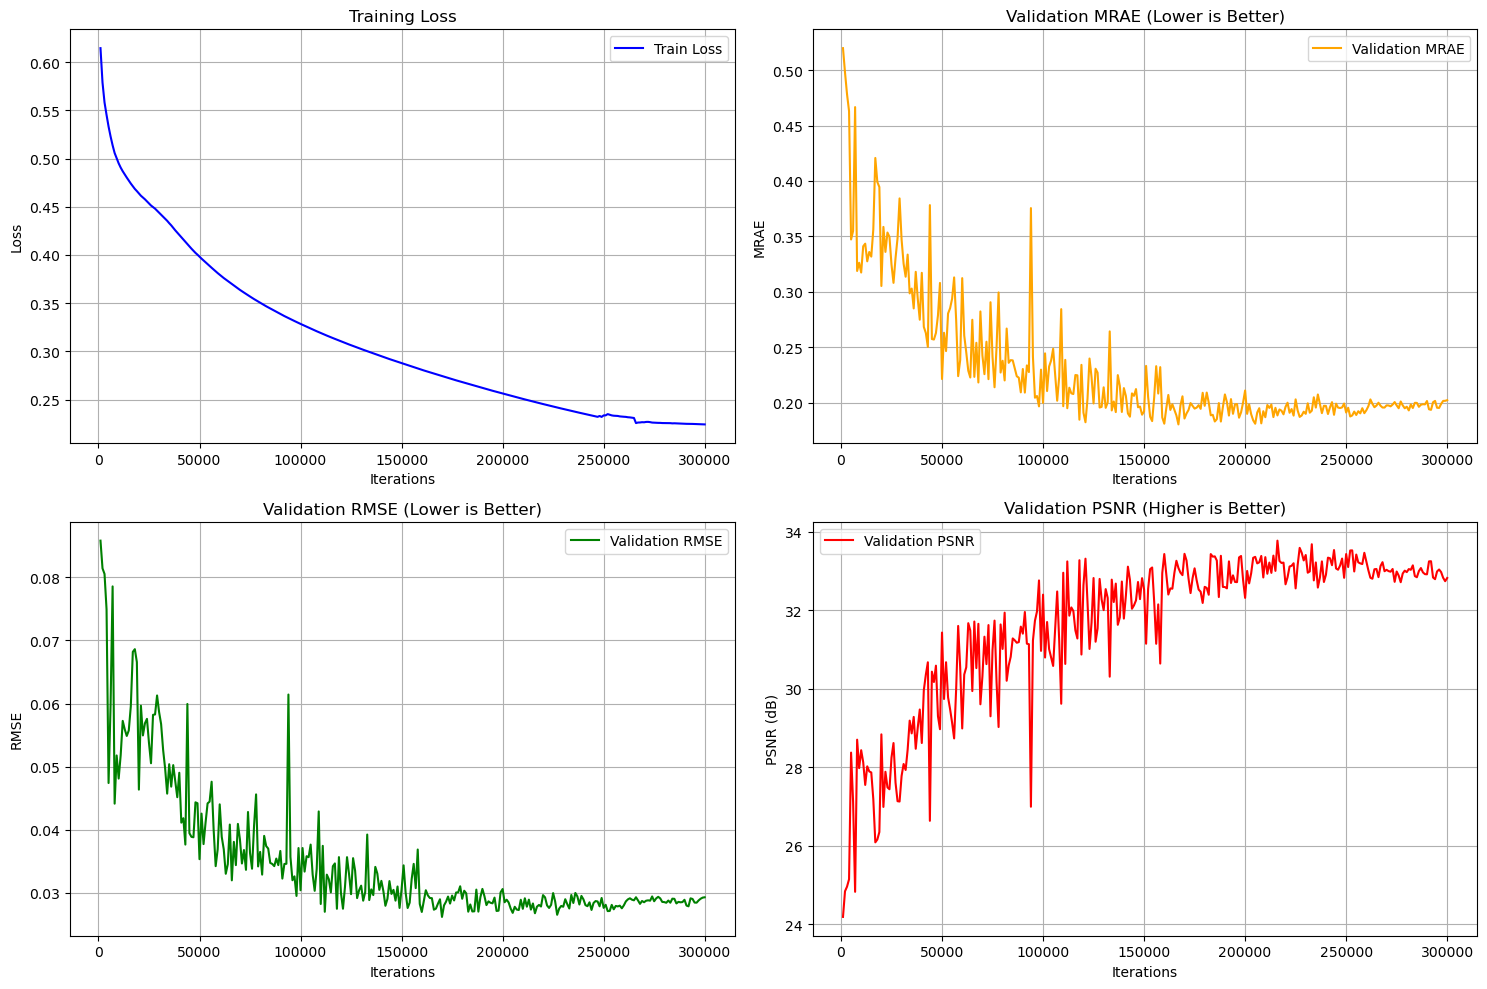

In [10]:
import matplotlib.pyplot as plt
import re
import os

log_file_path = os.path.join(opt.outf, 'train.log') 

def parse_log_file(log_path):
    iterations = []
    train_losses = []
    val_mraes = []
    val_rmses = []
    val_psnrs = []
    
    if not os.path.exists(log_path):
        print(f"Error: Log file not found at {log_path}")
        return None, None, None, None, None

    print(f"Reading log file: {log_path}")
    
    with open(log_path, 'r') as f:
        for line in f:
            if "Iter[" in line and "Test MRAE" in line:
                try:
                    # Extract data using regex
                    iter_match = re.search(r'Iter\[(\d+)\]', line)
                    train_loss_match = re.search(r'Train Loss:\s*([\d\.]+)', line)
                    mrae_match = re.search(r'Test MRAE:\s*([\d\.]+)', line)
                    rmse_match = re.search(r'Test RMSE:\s*([\d\.]+)', line)
                    psnr_match = re.search(r'Test PSNR:\s*([\d\.]+)', line)
                    
                    if iter_match and mrae_match:
                        iterations.append(int(iter_match.group(1)))
                        train_losses.append(float(train_loss_match.group(1)) if train_loss_match else 0)
                        val_mraes.append(float(mrae_match.group(1)))
                        val_rmses.append(float(rmse_match.group(1)) if rmse_match else 0)
                        val_psnrs.append(float(psnr_match.group(1)) if psnr_match else 0)
                except Exception as e:
                    print(f"Skipping line due to parse error: {line.strip()} | Error: {e}")

    return iterations, train_losses, val_mraes, val_rmses, val_psnrs

# Parse the data
iters, t_loss, v_mrae, v_rmse, v_psnr = parse_log_file(log_file_path)

# Plotting
if iters and len(iters) > 0:
    plt.figure(figsize=(15, 10))

    # Subplot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(iters, t_loss, label='Train Loss', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    # Subplot 2: MRAE
    plt.subplot(2, 2, 2)
    plt.plot(iters, v_mrae, label='Validation MRAE', color='orange')
    plt.xlabel('Iterations')
    plt.ylabel('MRAE')
    plt.title('Validation MRAE (Lower is Better)')
    plt.grid(True)
    plt.legend()

    # Subplot 3: RMSE
    plt.subplot(2, 2, 3)
    plt.plot(iters, v_rmse, label='Validation RMSE', color='green')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE (Lower is Better)')
    plt.grid(True)
    plt.legend()

    # Subplot 4: PSNR
    plt.subplot(2, 2, 4)
    plt.plot(iters, v_psnr, label='Validation PSNR', color='red')
    plt.xlabel('Iterations')
    plt.ylabel('PSNR (dB)')
    plt.title('Validation PSNR (Higher is Better)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No data found to plot. Check if the log file path is correct and contains validation steps.")


# best model pth selector

In [11]:
import re
import os
import glob

# ================= CONFIGURATION =================
LOG_FILE_PATH = "/home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09/train.log" 
CHECKPOINT_DIR = "/home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09/"
BEST_METRIC = 'mrae' 
# =================================================

def find_best_epoch_from_log(log_path, metric='mrae'):
    best_epoch = -1
    best_val = float('inf') if metric in ['mrae', 'rmse'] else float('-inf')
    best_line_data = {}

    if not os.path.exists(log_path):
        print(f"Error: Log file not found at {log_path}")
        return -1

    print(f"Scanning log file for best {metric.upper()}...")
    
    with open(log_path, 'r') as f:
        for line in f:
            if "Iter[" in line and "Test MRAE" in line:
                try:
                    # Extract Epoch
                    epoch_match = re.search(r'Epoch\[(\d+)\]', line)
                    if not epoch_match: continue
                    epoch = int(epoch_match.group(1))

                    # Extract Metrics
                    mrae_match = re.search(r'Test MRAE:\s*([\d\.]+)', line)
                    rmse_match = re.search(r'Test RMSE:\s*([\d\.]+)', line)
                    psnr_match = re.search(r'Test PSNR:\s*([\d\.]+)', line)

                    if not (mrae_match and rmse_match and psnr_match): continue

                    mrae = float(mrae_match.group(1))
                    rmse = float(rmse_match.group(1))
                    psnr = float(psnr_match.group(1))

                    # Logic for Best Model
                    is_best = False
                    if metric == 'mrae':
                        if mrae < best_val:
                            best_val = mrae
                            is_best = True
                    elif metric == 'rmse':
                        if rmse < best_val:
                            best_val = rmse
                            is_best = True
                    elif metric == 'psnr':
                        if psnr > best_val:
                            best_val = psnr
                            is_best = True
                    
                    if is_best:
                        best_epoch = epoch
                        best_line_data = {
                            'epoch': epoch,
                            'mrae': mrae,
                            'rmse': rmse,
                            'psnr': psnr
                        }

                except Exception as e:
                    continue

    return best_line_data

# --- EXECUTION ---
best_stats = find_best_epoch_from_log(LOG_FILE_PATH, BEST_METRIC)

if best_stats:
    print("\n" + "="*40)
    print(f"BEST MODEL FOUND (based on {BEST_METRIC.upper()})")
    print("="*40)
    print(f"Epoch: {best_stats['epoch']}")
    print(f"MRAE:  {best_stats['mrae']}")
    print(f"RMSE:  {best_stats['rmse']}")
    print(f"PSNR:  {best_stats['psnr']}")
    print("-" * 40)

    # Check if the file actually exists
    expected_filename = f"net_{best_stats['epoch']}epoch.pth"
    full_ckpt_path = os.path.join(CHECKPOINT_DIR, expected_filename)
    
    if os.path.exists(full_ckpt_path):
        print(f"Checkpoint file exists: {full_ckpt_path}")
        print("You can use this path for inference!")
    else:
        print(f"Warning: Ideally, the best model is at Epoch {best_stats['epoch']},")
        print(f"   but the file '{expected_filename}' was not found in the checkpoint directory.")
        print("   (Maybe it was deleted to save space, or checkpoints were only saved every N epochs?)")
        
        # Fallback: suggest closest existing file
        print("\nChecking for available files...")
        available_files = glob.glob(os.path.join(CHECKPOINT_DIR, "net_*epoch.pth"))
        if available_files:
            print(f"Found {len(available_files)} checkpoint files. Pick the one closest to epoch {best_stats['epoch']}.")
else:
    print("Could not determine best model from log.")


Scanning log file for best MRAE...

BEST MODEL FOUND (based on MRAE)
Epoch: 167
MRAE:  0.180639327
RMSE:  0.027520558
PSNR:  33.078277588
----------------------------------------
Checkpoint file exists: /home/shasvat/mtp/mst_plus_plus/exp/mst_plus_plus/2025_11_21_11_07_09/net_167epoch.pth
You can use this path for inference!


# Model Summary

In [18]:
from torchinfo import summary
mst_model = MST_Plus_Plus().to(device)
summary(mst_model, input_size=(1, 3, 128, 128))


Layer (type:depth-idx)                                                 Output Shape              Param #
MST_Plus_Plus                                                          [1, 31, 128, 128]         --
├─Conv2d: 1-1                                                          [1, 31, 128, 128]         837
├─Sequential: 1-2                                                      [1, 31, 128, 128]         --
│    └─MST: 2-1                                                        [1, 31, 128, 128]         --
│    │    └─Conv2d: 3-1                                                [1, 31, 128, 128]         8,649
│    │    └─ModuleList: 3-2                                            --                        216,724
│    │    └─MSAB: 3-3                                                  [1, 124, 32, 32]          191,584
│    │    └─ModuleList: 3-4                                            --                        111,107
│    │    └─Conv2d: 3-5                                                [1, 3